(ucp:title)=
# The Unit Commitment Problem

Here, we will solve a unit commitment (UC) problem described in the [tutorial of IBM Decision Optimization CPLEX for Python (DOcplex)](https://ibmdecisionoptimization.github.io/docplex-doc/mp/ucp_pandas.html). The electricity demand data and parameters of all generators are provided in the Excel file [uc_data.xlsx](uc_data.xlsx), see the code below.

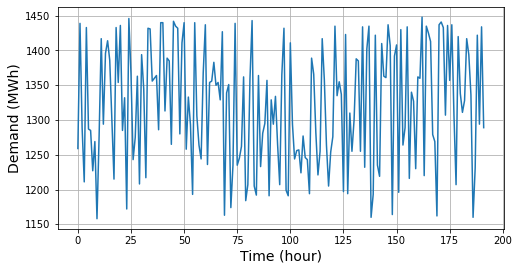

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

demand = pd.read_excel('uc_data.xlsx', 'Demand')     # Electricity demand 

plt.figure(figsize=(8, 4))
plt.plot(demand.index, demand['load'])
plt.xlabel('Time (hour)', fontsize=14)
plt.ylabel('Demand (MWh)', fontsize=14)
plt.grid()
plt.show()

In [2]:
units = pd.read_excel('uc_data.xlsx', 'Units')       # Parameters of generators
units

,name,energy,initial,min_gen,max_gen,uptime,downtime,ramp_up,ramp_down,start_cost,fixed_cost,variable_cost,co2_cost
0,coal1,coal,400,100.00,425,15,9,212.0,183.0,5000,208.610,22.536,30
1,coal2,coal,350,140.00,365,15,8,150.0,198.0,4550,117.370,31.985,30
2,gas1,gas,205,78.00,220,6,7,101.2,95.6,1320,174.120,70.500,5
3,gas2,gas,52,52.00,210,5,4,94.8,101.7,1291,172.750,69.000,5
4,gas3,gas,155,54.25,165,5,3,58.0,77.5,1280,95.353,32.146,5
5,gas4,gas,150,39.00,158,4,2,50.0,60.0,1105,144.520,54.840,5
6,diesel1,diesel,78,17.40,90,3,2,40.0,24.0,560,54.417,40.222,15
7,diesel2,diesel,76,15.20,87,3,2,60.0,45.0,554,54.551,40.522,15
8,diesel3,diesel,0,4.00,20,1,1,20.0,20.0,300,79.638,116.330,15
9,diesel4,diesel,0,2.40,12,1,1,12.0,12.0,250,16.259,76.642,15


Parameters of units are defined by the code segment below,

In [3]:
g_init = units['initial'].values
u_init = (g_init > 0).astype(int)
g_min = units['min_gen'].values
g_max = units['max_gen'].values
h_up = units['uptime'].values
h_down = units['downtime'].values
r_up = units['ramp_up'].values
r_down = units['ramp_down'].values
a = units['fixed_cost'].values
b = units['variable_cost'].values
c = units['start_cost'].values
d = demand['load'].values
e = units['co2_cost'].values

and detailed information on these parameters is provided in the following table.

| Notation | Interpretation | Array Expression | Variable |
|:--------|:--------------|:----------------|:--------|
|$g_n^{\text{init}}$ | The initial output of the $n$th generator | `units['initial'].values`| `g_init` |
|$u_n^{\text{init}}$ | The initial on/off status of the $n$th generator | `(g_init > 0).astype(int)`| `u_init` |
|$g_n^{\min}$ | The minimum capacity of the $n$th generator | `units['min'].values`| `g_min` |
|$g_n^{\max}$ | The maximum capacity of the $n$th generator | `units['max'].values`| `g_max` |
|$h_n^{\text{up}}$ | The minimum up time of the $n$th generator | `units['uptime'].values`| `h_up` |
|$h_n^{\text{down}}$ | The minimum down time of the $n$th generator | `units['downtime'].values`| `h_down` |
|$r_n^{\text{up}}$ | The ramp-up rate limit of the $n$th generator | `units['ramp_up'].values`| `r_up` |
|$h_n^{\text{down}}$ | The ramp-down rate limit of the $n$th generator | `units['ramp_down'].values`| `r_down` |
|$a_n$ | The fixed cost of the $n$th generator | `units['fixed_cost'].values`| `a` |
|$b_n$ | The variable cost of the $n$th generator | `units['variable_cost'].values`| `b` |
|$c_n$ | The start-up cost of the $n$th generator | `units['start_cost'].values`| `c` |
|$d_t$ | The electricity demand at time step $t$ | `demand['load'].values`| `d` |
|$e_n$ | The CO2 emission cost of the $n$th generator | `units['co2_cost'].values`| `e` |

The UC model below is used to determine the optimal schedule of on/off status of generators:

$$
\begin{align}
\min~&\sum\limits_{t=1}^T\sum\limits_{n=1}^N\left(a_nu_{tn} + b_ng_{tn} + c_nv_{tn} + e_ng_{tn}\right) \hspace{-1in}& \tag{1}\\
\text{s.t.}~&v_{1n} \geq u_{1n} - u_n^{\text{init}}, ~v_{1n} \geq 0 &\forall n= 1, ..., N \tag{2}\\
&v_{tn} \geq u_{tn} - u_{(t-1)u}, ~v_{tn} \geq 0 & \forall t = 2, ..., T, \forall n = 1, ..., N \tag{3}\\
&w_{1n} \geq u_n^{\text{init}} - u_{1n}, w_{1n} \geq 0 &\forall n= 1, ..., N \tag{4}\\
&w_{tn} \geq u_{(t-1)u} - u_{tn}, w_{tn} \geq 0 & \forall t = 2, ..., T, \forall n = 1, ..., N \tag{5}\\
&\sum\limits_{k=t-h_n^{\text{up}}}^tv_{tn} \leq u_{tn} & \forall t=h_n^{\text{up}}+1, ..., T, \forall n = 1, ..., N \tag{6}\\
&\sum\limits_{k=t-h_n^{\text{down}}}^tw_{tn} \leq 1 - u_{tn} & \forall t=h_n^{\text{down}}+1, ..., T, \forall n = 1, ..., N \tag{7}\\
&\sum\limits_{n=1}^Tg_{tn} = d_{t} &\forall t=1, ..., T \tag{8}\\
&u_{tn}g_n^{\text{min}} \leq g_{tn} \leq u_{tn}g_n^{\text{max}} &\forall t=1, ..., T, \forall n = 1, ..., N \tag{9}\\
&g_{1n} - g_n^{\text{init}} \leq r_n^{\text{up}} &\forall n = 1, ..., N \tag{10}\\
&g_{tn} - g_{(t-1)n} \leq r_n^{\text{up}} &\forall t=2, ..., T, \forall n=1, ..., N \tag{11}\\
&g_n^{\text{init}} - g_{1n} \leq r_n^{\text{down}} &\forall n = 1, ..., N \tag{12}\\
&g_{(t-1)n} - g_{tn} \leq r_n^{\text{down}} &\forall t=2, ..., T, \forall n=1, ..., N \tag{13} 
\end{align}
$$

where $T$ is the number of time steps, and $N$ is the number of generator units, with the decision variables

| Notation | Interpretation | Variable |
|:---------|:---------------|:---------|
| $u_{tn}$ | Binary variable indicating the on/off status of the $n$th generator at the time step $t$ | `u` |
| $v_{tn}$ | Binary variable indicating the start-up of the $n$th generator at the time step $t$ | `v` |
| $w_{tn}$ | Binary variable indicating the shut-down status of the $n$th generator at the time step $t$ | `w` |
| $g_{tn}$ | Continuous variable representing the output of the $n$th generator at the time step $t$ | `g` |

The UC model above minimizes the total cost of generation and emission, expressed by equation $(1)$, subject to 
- Constraints $(2)-(3)$ for the switch-on status of generator units;
- Constraints $(4)-(5)$ for the switch-off status of generator units;
- Minimum up-time constraints $(6)$ and minimum down-time constraints $(7)$;
- Power balance equations $(8)$;
- Power generation capacity constraints $(9)$;
- Generator ramp-up limits $(10)-(11)$ and ramp-down limits $(12)-(13)$.

Such a model can be solved with RSOME using the following code.

In [4]:
from rsome import ro

N = units.shape[0]                                            # N as the number of units
T = len(d)                                                    # T as the number of time steps

model = ro.Model('UC')                                        # Create a model named 'UC'

u = model.dvar((T, N), 'B')                                   # Unit on/off status
v = model.dvar((T, N), 'B')                                   # Switch-on status of units
w = model.dvar((T, N), 'B')                                   # Switch-off status of units
g = model.dvar((T, N))                                        # Generation outputs

model.min((a*u + b*g + c*v + e*g).sum())                      # Minimize the total cost (1)
model.st(v[0] >= u[0] - u_init, 
         v[1:] >= u[1:] - u[:-1],
         v >= 0)                                              # Switch-on status of units (2)-(3)
model.st(w[0] >=  u_init - u[0], 
         w[1:] >= u[:-1] - u[1:],
         w >= 0)                                              # Switch-off status of units (4)-(5) 
for n in range(N):
    model.st(v[t-h_up[n]+1:t+1, n].sum() <= u[t, n] 
             for t in range(h_up[n], T))                      # Minimum up-time constraints (6)
    model.st(w[t-h_down[n]+1:t+1, n].sum() <= 1 - u[t, n]
             for t in range(h_down[n], T))                    # Minimum down-time constraints (7)
model.st(g.sum(axis=1) == d)                                  # Power balance equation (8)
model.st(g >= u*g_min,                                      
         g <= u*g_max)                                        # Minimum/aaximum capacities of units (9)
model.st(g[0] - g_init <= r_up,                               # Ramp-up rate limits (10)-(11)
         g[1:] - g[:-1] <= r_up,
         g_init - g[0] <= r_down,
         g[:-1] - g[1:] <= r_down)                            # Ramp-down rate limits (12)-(13)

model.solve()                                                 # Solve the model

Being solved by the default MILP solver...
Solution status: 0
Running time: 1.0400s


Similar to the case study discussed in the [IBM CPLEX tutorial](https://ibmdecisionoptimization.github.io/docplex-doc/mp/ucp_pandas.html), the total operating cost and the breakdown of each cost component is calculated and listed below.

In [5]:
print(f'Total cost:          {model.get():12.3f}')
print(f'Total fixed cost:    {(a * u.get()).sum():12.3f}')
print(f'Total variable cost: {(b * g.get()).sum():12.3f}')
print(f'Total start-up cost: {(c * v.get()).sum():12.3f}')
print(f'Total economic cost: {(a*u.get() + b*g.get() + c*v.get()).sum():12.3f}')
print(f'Total CO2 cost:      {(e * g.get()).sum():12.3f}')

Total cost:          14213082.064
Total fixed cost:      161025.131
Total variable cost:  8865900.433
Total start-up cost:     2832.000
Total economic cost:  9029757.564
Total CO2 cost:       5183324.500


The optimal schedule in terms of generation from each type of generators is shown as follows.

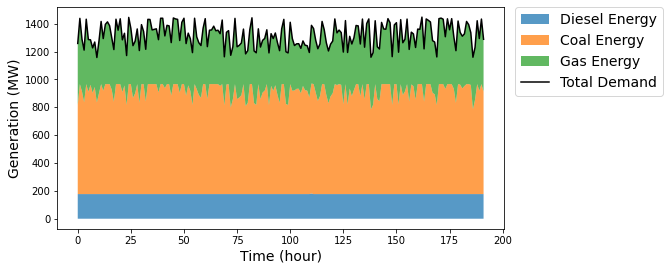

In [8]:
gen = units[['name', 'energy']].copy()
gen = pd.concat((gen, pd.DataFrame(g.get().T)), axis=1)

outputs = gen.groupby('energy')[np.arange(T)].sum()

plt.figure(figsize=(8, 4))
energy = ['diesel', 'coal', 'gas']
bottom = 0
for label in energy:
    ydata = outputs.loc[label]
    plt.fill_between(range(T), bottom, bottom+ydata, alpha=0.75, label=f'{label} energy'.title())
    bottom += ydata
    
plt.plot(range(T), d, color='k', label='Total Demand')

plt.legend(bbox_to_anchor=(1.01, 1.03), fontsize=14)

plt.xlabel('Time (hour)', fontsize=14)
plt.ylabel('Generation (MW)', fontsize=14)
plt.show()